![](https://debuggercafe.com/wp-content/uploads/2021/04/vgg_architectures_table.jpg)

In [1]:
import time
import copy

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
import torchvision.datasets as datasets

import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_epochs = 10
num_classes = 10
batch_size = 16
learning_rate = 0.001

In [4]:
torch.manual_seed(0)

def tile_image(image):
    '''duplicate along channel axis'''
    return image.repeat(3,1,1)

transform=transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: tile_image(x))
        ])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, transform=transform)

# Before
print('Train data set:', len(train_dataset))
print('Test data set:', len(test_dataset))

# Random split
train_set_size = int(len(train_dataset) * 0.8)
indices = list(range(train_set_size))
split = int(np.floor(.2 * train_set_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler =  SequentialSampler(val_indices)
   

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=train_sampler,
                                           batch_size=batch_size,
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=valid_sampler,
                                           batch_size=batch_size,
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Train data set: 60000
Test data set: 10000


In [5]:
def conv_layer_b(channel_input, channel_output):
    layer = nn.Sequential(
        nn.Conv2d(channel_input, channel_output, kernel_size=3, padding=1),
        nn.BatchNorm2d(channel_output),
        nn.ReLU()
    )
    return layer

In [6]:
def conv_layer(channel_input, channel_output):
    layer = nn.Sequential(
        nn.Conv2d(channel_input, channel_output, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )
    return layer

In [7]:
def vgg_conv_block_b(input_list, output_list):
    layers = [conv_layer_b(input_list[i], output_list[i]) for i in range(len(input_list))]
    layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    return nn.Sequential(*layers)

In [8]:
def vgg_conv_block(input_list, output_list):
    layers = [conv_layer(input_list[i], output_list[i]) for i in range(len(input_list))]
    layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    return nn.Sequential(*layers)

In [9]:
def vgg_full_connected_layer(size_input, size_output):
    layer = nn.Sequential(
        nn.Linear(size_input, size_output),
        nn.BatchNorm1d(size_output),
        nn.ReLU(),
    )
    return layer

In [ ]:
class VGG11(nn.Module):
    def __init__(self, n_classes=1000):
        super(VGG11, self).__init__()
        # Conv blocks (BatchNorm + ReLU activation added in each block)

        ### Block 01
        ### Contain 1 convolution layers and 1 maxpool layer
        ### Convolution layer has 64 filters, kernel size 3x3, activation function ReLU
        self.layer1 = vgg_conv_block(input_list=[3], output_list=[64])

        ### Block 02
        ### Contain 1 convolution layers and 1 maxpool layer
        ### Convolution layer has 128 filters, kernel size 3x3, activation function ReLU
        self.layer2 = vgg_conv_block(input_list=[64], output_list=[128])

        ### Block 03
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 256 filters, kernel size 1x1, activation function ReLU
        self.layer3 = vgg_conv_block(input_list=[128, 256], output_list=[256, 256])

        ### Block 04
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 512 filters, kernel size 3x3, activation function ReLU
        self.layer4 = vgg_conv_block(input_list=[256, 512], output_list=[512, 512])


        ### Block 05
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 512 filters, kernel size 3x3, activation function ReLU
        self.layer5 = vgg_conv_block(input_list=[512, 512], output_list=[512, 512])


        ## Full-Connected Layer
        self.layer6 = vgg_full_connected_layer(size_input=512, size_output=4096)
        self.layer7 = vgg_full_connected_layer(size_input=4096, size_output=4096)

        ## Final layer
        self.layer8 = nn.Linear(4096, n_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        vgg11_features = self.layer5(x)
        x = vgg11_features.view(x.size(0), -1)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        return x

In [ ]:
class VGG13(nn.Module):
    def __init__(self, n_classes=1000):
        super(VGG13, self).__init__()
        # Conv blocks (BatchNorm + ReLU activation added in each block)

        ### Block 01
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 64 filters, kernel size 3x3, activation function ReLU
        self.layer1 = vgg_conv_block(input_list=[3, 64], output_list=[64, 64])

        ### Block 02
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 128 filters, kernel size 3x3, activation function ReLU
        self.layer2 = vgg_conv_block(input_list=[64, 128], output_list=[128, 128])

        ### Block 03
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 256 filters, kernel size 1x1, activation function ReLU
        self.layer3 = vgg_conv_block(input_list=[128, 256], output_list=[256, 256])

        ### Block 04
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 512 filters, kernel size 3x3, activation function ReLU
        self.layer4 = vgg_conv_block(input_list=[256, 512], output_list=[512, 512])


        ### Block 05
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 512 filters, kernel size 3x3, activation function ReLU
        self.layer5 = vgg_conv_block(input_list=[512, 512], output_list=[512, 512])


        ## Full-Connected Layer
        self.layer6 = vgg_full_connected_layer(size_input=512, size_output=4096)
        self.layer7 = vgg_full_connected_layer(size_input=4096, size_output=4096)

        ## Final layer
        self.layer8 = nn.Linear(4096, n_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        vgg13_features = self.layer5(x)
        x = vgg13_features.view(x.size(0), -1)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        return x

In [ ]:
class VGG16_1(nn.Module):
    def __init__(self, n_classes=1000):
        super(VGG16_1, self).__init__()
        # Conv blocks (BatchNorm + ReLU activation added in each block)

        ### Block 01
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 64 filters, kernel size 3x3, activation function ReLU
        self.layer1 = vgg_conv_block(input_list=[3, 64], output_list=[64, 64])

        ### Block 02
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 128 filters, kernel size 3x3, activation function ReLU
        self.layer2 = vgg_conv_block(input_list=[64, 128], output_list=[128, 128])

        ### Block 03
        ### Contain 3 convolution layers and 1 maxpool layer
        ### Convolution layer has 256 filters, kernel size 1x1, activation function ReLU
        self.layer3 = vgg_conv_block(input_list=[128, 256, 256], output_list=[256, 256, 256])

        ### Block 04
        ### Contain 3 convolution layers and 1 maxpool layer
        ### Convolution layer has 512 filters, kernel size 3x3, activation function ReLU
        self.layer4 = vgg_conv_block(input_list=[256, 512, 512], output_list=[512, 512, 512])


        ### Block 05
        ### Contain 3 convolution layers and 1 maxpool layer
        ### Convolution layer has 512 filters, kernel size 3x3, activation function ReLU
        self.layer5 = vgg_conv_block(input_list=[512, 512, 512], output_list=[512, 512, 512])


        ## Full-Connected Layer
        self.layer6 = vgg_full_connected_layer(size_input=512, size_output=4096)
        self.layer7 = vgg_full_connected_layer(size_input=4096, size_output=4096)

        ## Final layer
        self.layer8 = nn.Linear(4096, n_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        vgg16_1_features = self.layer5(x)
        x = vgg16_1_features.view(x.size(0), -1)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        return x

In [10]:
class VGG16(nn.Module):
    def __init__(self, n_classes=1000):
        super(VGG16, self).__init__()
        # Conv blocks (BatchNorm + ReLU activation added in each block)

        # Block 01
        # Contain 2 convolution layers and 1 maxpool layer
        # Convolution layer has 64 filters, kernel size 3x3, activation function ReLU
        self.layer1 = vgg_conv_block(input_list=[3, 64], output_list=[64, 64])

        # Block 02
        # Contain 2 convolution layers and 1 maxpool layer
        # Convolution layer has 128 filters, kernel size 3x3, activation function ReLU
        self.layer2 = vgg_conv_block(input_list=[64, 128], output_list=[128, 128])

        # Block 03
        # Contain 3 convolution layers and 1 maxpool layer
        # Convolution layer has 256 filters, kernel size 3x3, activation function ReLU
        self.layer3 = vgg_conv_block(input_list=[128, 256, 256], output_list=[256, 256, 256])

        # Block 04
        # Contain 3 convolution layers and 1 maxpool layer
        # Convolution layer has 512 filters, kernel size 3x3, activation function ReLU
        self.layer4 = vgg_conv_block(input_list=[256, 512, 512], output_list=[512, 512, 512])

        # Block 05
        # Contain 3 convolution layers and 1 maxpool layer
        # Convolution layer has 512 filters, kernel size 3x3, activation function ReLU
        self.layer5 = vgg_conv_block(input_list=[512, 512, 512], output_list=[512, 512, 512])

        ## Full-Connected Layer
        self.layer6 = vgg_full_connected_layer(size_input=512, size_output=4096)
        self.layer7 = vgg_full_connected_layer(size_input=4096, size_output=4096)

        ## Final layer
        self.layer8 = nn.Linear(4096, n_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        vgg16_features = self.layer5(x)
        x = vgg16_features.view(x.size(0), -1)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        return x

In [ ]:
class VGG19(nn.Module):
    
    def __init__(self, n_classes=1000):
        super(VGG19, self).__init__()
        # Conv blocks (BatchNorm + ReLU activation added in each block)

        ### Block 01
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 64 filters, kernel size 3x3, activation function ReLU
        self.layer1 = vgg_conv_block(input_list=[3, 64], output_list=[64, 64])

        ### Block 02
        ### Contain 2 convolution layers and 1 maxpool layer
        ### Convolution layer has 128 filters, kernel size 3x3, activation function ReLU
        self.layer2 = vgg_conv_block(input_list=[64, 128], output_list=[128, 128])

        ### Block 03
        ### Contain 4 convolution layers and 1 maxpool layer
        ### Convolution layer has 256 filters, kernel size 3x3, activation function ReLU
        self.layer3 = vgg_conv_block(input_list=[128, 256, 256, 256], output_list=[256, 256, 256, 256])

        ### Block 04
        ### Contain 4 convolution layers and 1 maxpool layer
        ### Convolution layer has 512 filters, kernel size 3x3, activation function ReLU
        self.layer4 = vgg_conv_block(input_list=[256, 512, 512, 512], output_list=[512, 512, 512, 512])


        ### Block 05
        ### Contain 4 convolution layers and 1 maxpool layer
        ### Convolution layer has 512 filters, kernel size 3x3, activation function ReLU
        self.layer5 = vgg_conv_block(input_list=[512, 512, 512], output_list=[512, 512, 512])


        ## Full-Connected Layer
        self.layer6 = vgg_full_connected_layer(size_input=512, size_output=4096)
        self.layer7 = vgg_full_connected_layer(size_input=4096, size_output=4096)

        ## Final layer
        self.layer8 = nn.Linear(4096, n_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        vgg19_features = self.layer5(x)
        x = vgg19_features.view(x.size(0), -1)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        return x

In [11]:
alpha_ratio = 0.3 # weight ratio for L1 Regularization
beta_ratio = 0.7 # weight ratio for L2 Regularization

def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25, scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # compute loss
                    loss = criterion(outputs, labels)


                    # compute L1 loss component
                    l1_loss = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
                    reg_loss_l1 = 0 
                    for param in model.parameters():
                        zero_vector = torch.rand_like(param) * 0
                        reg_loss_l1 += l1_loss(param, zero_vector)

                    # compute L2 loss component
                    l2_loss = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
                    reg_loss_l2 = 0 
                    for param in model.parameters():
                        zero_vector = torch.rand_like(param) * 0
                        reg_loss_l2 += l2_loss(param, zero_vector)

                    # compute L2 loss component
                    l1_weight = alpha_ratio
                    l2_weight = beta_ratio
                    
                    # combine L1 and L2
                    l1 = l1_weight * reg_loss_l1
                    l2 = l2_weight * reg_loss_l2
                    reg = l1 + l2
      
                    # add L2 loss component
                    loss += reg

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

VGG16(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), st

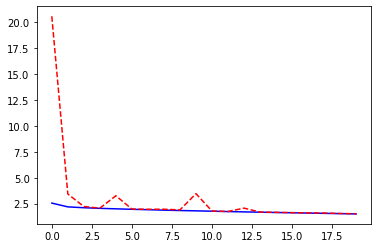

In [ ]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = VGG16(num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

VGG16(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), st

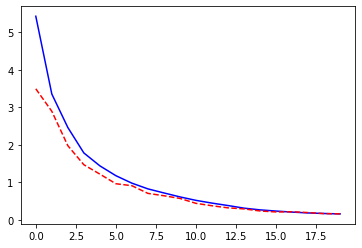

In [ ]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = VGG16(num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

VGG16(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), st

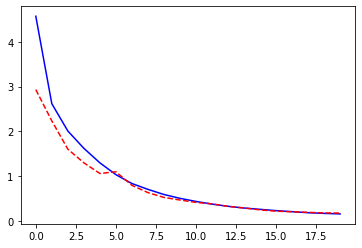

In [12]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = VGG16(num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, nesterov=True)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

VGG16(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), st

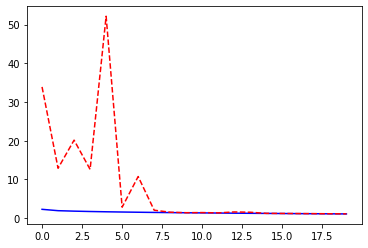

In [13]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = VGG16(num_classes).to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

VGG16(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), st

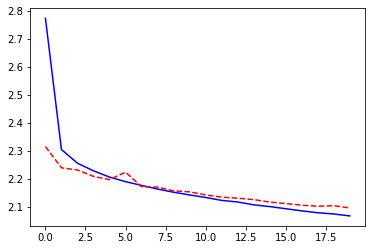

In [14]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = VGG16(num_classes).to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

VGG16(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), st

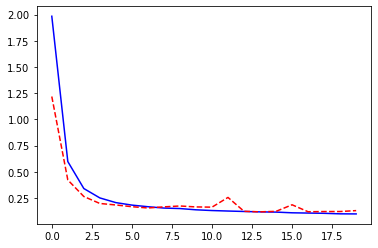

In [15]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = VGG16(num_classes).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

VGG16(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), st

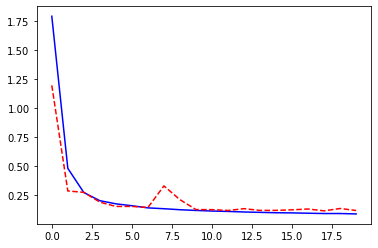

In [16]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = VGG16(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))